# Libs

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier

ROOT_DIR = Path(os.getcwd())
TRAIN_PATH = ROOT_DIR / "data/train.csv"
TEST_PATH = ROOT_DIR / "data/test.csv"
SAMPLE_PATH = ROOT_DIR / "data/sample_submission.csv"

# Load

In [30]:
train = pd.read_csv(TRAIN_PATH)

test = pd.read_csv(TEST_PATH)

# EDA

In [3]:
print(train.shape)
print(train.columns)

(165034, 14)
Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
train.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [7]:
train.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# Feature Engineering

In [8]:
age_gap = [
    0, 34, 42, 65, 70, 200
]
age_labels = [1, 2, 3, 4, 5]
train["age_group"] = pd.cut(train['Age'], bins=age_gap, labels=age_labels, right=True)
train['age_group'] = pd.factorize(train['age_group'])[0] + 1

In [18]:
train['age_group']

0         1
1         1
2         2
3         1
4         1
         ..
165029    1
165030    2
165031    1
165032    1
165033    1
Name: age_group, Length: 165034, dtype: int64

In [9]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,2
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1


In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


<Axes: xlabel='Exited', ylabel='count'>

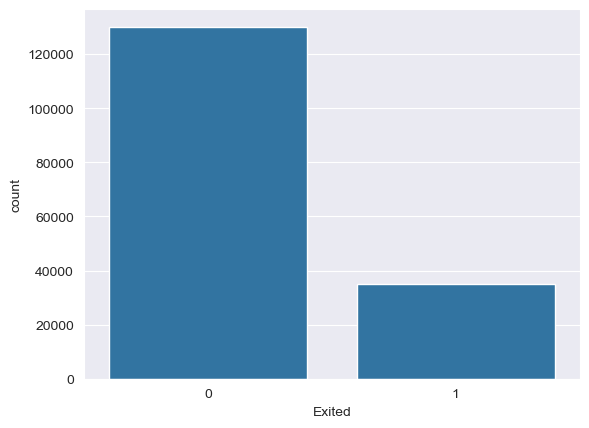

In [11]:
sns.countplot(data=train,x=train.Exited)

In [12]:
train_target = train.Exited
train_df = train.drop(["id", "CustomerId", "Exited"], axis=1)
X, y = train_df, train_target
del train_df, train_target

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Surname          165034 non-null  object 
 1   CreditScore      165034 non-null  int64  
 2   Geography        165034 non-null  object 
 3   Gender           165034 non-null  object 
 4   Age              165034 non-null  float64
 5   Tenure           165034 non-null  int64  
 6   Balance          165034 non-null  float64
 7   NumOfProducts    165034 non-null  int64  
 8   HasCrCard        165034 non-null  float64
 9   IsActiveMember   165034 non-null  float64
 10  EstimatedSalary  165034 non-null  float64
 11  age_group        165034 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 15.1+ MB


In [14]:
cate_features = list(X.select_dtypes(include="object").columns)
cate_features

['Surname', 'Geography', 'Gender']

In [15]:
classes = np.unique(y)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6341948921322236, 1: 2.362962114486985}

# Modeling

In [16]:
params = {
    'iterations':8000,
    'learning_rate':0.005,
    'loss_function':'MultiClass',
    'random_seed':42,
    'l2_leaf_reg':1,
    'max_ctr_complexity':15,
    'max_depth':10,
    "grow_policy":'Lossguide',
    'max_leaves':64,
    "min_data_in_leaf":40,
}

In [17]:
model = CatBoostClassifier(**params, class_weights=class_weights)
model.fit(X, y, cat_features = cate_features, verbose=1000)

0:	learn: 0.6910485	total: 222ms	remaining: 29m 32s
1000:	learn: 0.4134046	total: 1m 23s	remaining: 9m 47s
2000:	learn: 0.4050133	total: 2m 30s	remaining: 7m 32s
3000:	learn: 0.3987946	total: 3m 25s	remaining: 5m 42s
4000:	learn: 0.3924267	total: 4m 14s	remaining: 4m 14s
5000:	learn: 0.3866436	total: 5m 2s	remaining: 3m 1s
6000:	learn: 0.3813396	total: 5m 50s	remaining: 1m 56s
7000:	learn: 0.3762263	total: 6m 43s	remaining: 57.5s
7999:	learn: 0.3714622	total: 7m 58s	remaining: 0us


In [31]:
age_gap = [
    0, 34, 42, 65, 70, 200
]
age_labels = [1, 2, 3, 4, 5]
test["age_group"] = pd.cut(test['Age'], bins=age_gap, labels=age_labels, right=True)
test['age_group'] = pd.factorize(test['age_group'])[0] + 1

In [32]:
X.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'age_group'],
      dtype='object')

In [36]:
test_df.columns

Index(['Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'age_group'],
      dtype='object')

In [35]:
test_df = test.drop(["id", "CustomerId"], axis=1)

In [38]:
submission = pd.DataFrame(
    {
        "id": test.id,
        "Exited": model.predict_proba(test_df)[:, 1]
    }
)
submission.to_csv("submission_v1.0.csv", index=False)